## **Student Performance Indicator**

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [149]:
df=pd.read_csv(r'data\stud.csv')

In [150]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### This is a regression problem. Here we'll consider all other variables / features except maths_score as indepedent variable and using them we would predict the math score of a child

In [151]:
x=df.drop(columns=['math_score'],axis=1) #drop along columns(axis=1) and drop the maths_score column from the x or training dataset
y=df['math_score'] # store the maths_score as y variable or target data that we need to predict

In [152]:
x.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [153]:
y.head()

0    72
1    69
2    90
3    47
4    76
Name: math_score, dtype: int64

In [154]:
x.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'reading_score', 'writing_score'],
      dtype='object')

In [155]:
# Categorical features
ordinal_features = ['parental_level_of_education']
nominal_features = ['gender', 'race_ethnicity', 'lunch', 'test_preparation_course']

# Numerical features (example)
numerical_features = x.select_dtypes(exclude='object').columns


#### Since our dataset has both numerical and categorical column and we know that the categories are not internally correlated to each other

* race_ethnicity -> feels ordered..but here its not like someone who brings good marks gets class A or so on..therefore nominal and so does the rest
* gender, lunch, test_preparation_cours are nominal categories
* parental_level_of_education is ordinal since the education of parent actively influences our exam results


**Order Of Ordinal Categorical Data (parental_education)**

some high school < high school < some college < associate's degree < bachelor's degree < master's degree


*Therefore to operate this independently we create Column Transformers*

In [156]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler # since our model is almost gaussian in nature we use Standardisation
from sklearn.compose import ColumnTransformer

In [157]:
# Categorical Transformation Section

#-> Ordinal Encoding Section
ordinal_mapping = [
    ['some high school',
     'high school',
     'some college',
     "associate's degree",
     "bachelor's degree",
     "master's degree"]
]
ordinal_transformer = OrdinalEncoder(categories=ordinal_mapping)

#-> Nominal Encoding Section
Nominal_transformer=OneHotEncoder(handle_unknown='ignore')


In [158]:
# Numerical Transformation Section

scaler=StandardScaler()

In [159]:
preprocessor=ColumnTransformer(
    transformers=[
        ('ordinal',ordinal_transformer,ordinal_features), # transformers=[(assign name to the transformer,transformer_object,data_that_needs_transformation)]
        ('nominal',Nominal_transformer,nominal_features),
        ('num',scaler,numerical_features)
    ]
)

In [160]:
X=preprocessor.fit_transform(x)

In [161]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [162]:
x_train

array([[ 5.        ,  1.        ,  0.        , ...,  1.        ,
         0.05694554,  0.45733301],
       [ 4.        ,  1.        ,  0.        , ...,  0.        ,
         0.94779033,  0.98406266],
       [ 2.        ,  1.        ,  0.        , ...,  1.        ,
         1.35894946,  1.18158627],
       ...,
       [ 3.        ,  1.        ,  0.        , ...,  1.        ,
        -0.49126664, -0.99117351],
       [ 2.        ,  0.        ,  1.        , ...,  0.        ,
        -1.45063795, -0.99117351],
       [ 3.        ,  1.        ,  0.        , ...,  1.        ,
         1.4960025 ,  1.37910989]], shape=(800, 14))

In [163]:
x_test.shape, x_train.shape

((200, 14), (800, 14))

In [164]:
def evaluate_model(true,predicted):

    # Mean Absolute Error
    MAE=mean_absolute_error(true,predicted)

    # Mean Standard Error
    MSE=mean_squared_error(true,predicted)

    # Root Mean Standard Error
    RMSE=root_mean_squared_error(true,predicted)

    #R2_score
    r2=r2_score(true,predicted)

    return MAE, MSE, RMSE, r2

In [165]:
models={
    'Linear Regression':LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'KNN': KNeighborsRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGB': XGBRegressor(),
    'Cat':CatBoostRegressor(verbose=False),
    'AdaBoost':AdaBoostRegressor()
}
model_list=[]
r2_list=[]

for i in range(len(list(models))):

    # Selcet one model object from the dictionary provided each time
    model=list(models.values())[i]
    model.fit(x_train,y_train) # train the model

    y_train_pred=model.predict(x_train) # predictions on training data 
    y_test_pred=model.predict(x_test)   # predictions on testing data 

    train_mae, train_mse, train_rmse, train_r2=evaluate_model(y_train,y_train_pred)
    test_mae, test_mse, test_rmse, test_r2=evaluate_model(y_test,y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(train_mae))
    print("- R2 Score: {:.4f}".format(train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(test_mae))
    print("- R2 Score: {:.4f}".format(test_r2))
    r2_list.append(test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3370
- Mean Absolute Error: 4.2804
- R2 Score: 0.8737
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3685
- Mean Absolute Error: 4.1820
- R2 Score: 0.8816


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3373
- Mean Absolute Error: 4.2790
- R2 Score: 0.8736
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3650
- Mean Absolute Error: 4.1806
- R2 Score: 0.8817


KNN
Model performance for Training set
- Root Mean Squared Error: 5.5680
- Mean Absolute Error: 4.4345
- R2 Score: 0.8625
----------------------------------
Model 

In [166]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.881715
0,Linear Regression,0.881560
8,AdaBoost,0.853436
7,Cat,0.851419
5,Random Forest,0.849667
6,XGB,0.837122
1,Lasso,0.825320
3,KNN,0.784802
4,DecisionTree,0.744759


### Working with Linear regression since it achieves the best performance

In [167]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(x_train, y_train)
y_pred = lin_model.predict(x_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.16


Text(0, 0.5, 'Predicted')

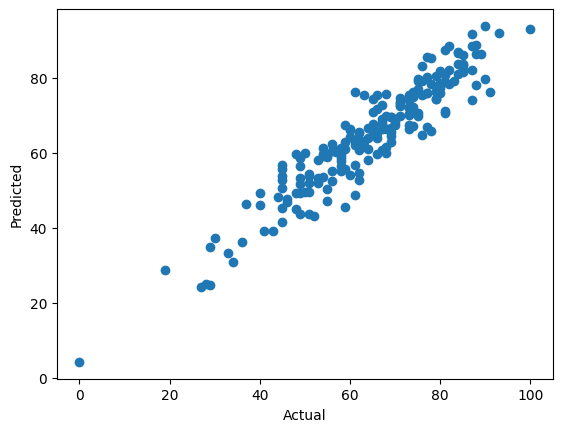

In [168]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

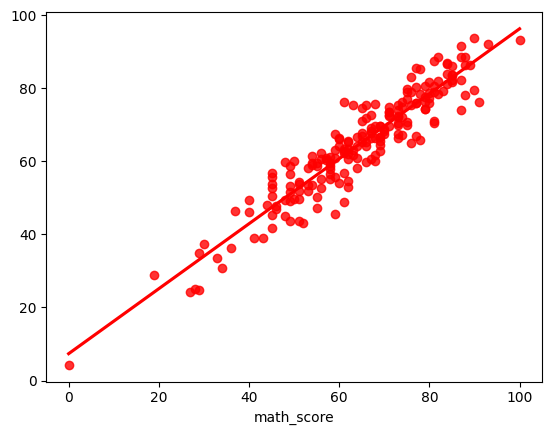

In [ ]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')